In [284]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

import datetime
import yfinance as yf

In [285]:
start = datetime.datetime(2015, 6, 1)
end = datetime.datetime(2023, 6, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers ,start ,end)['Close']
df.dropna(inplace=True)
#most recent data
df.tail()

import matplotlib.pyplot as plt
ADBE = df['ADBE']
MSFT = df['MSFT'] 

ADBE_std = (ADBE - ADBE.mean()) / ADBE.std()
MSFT_std = (MSFT - MSFT.mean()) / MSFT.std()



[*********************100%***********************]  2 of 2 completed


In [286]:
def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted

#--------------------------------------------------------------------------------------

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------

def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)

    return adf[1]

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

#--------------------------------------------------------------------------------------

def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted


def backtest(s1, s2, x, y ):

    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 2
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

In [287]:
ratio = df['ADBE'] / df['MSFT']

data = pd.DataFrame({'ADBE': ADBE, 'MSFT': MSFT, 'Ratio': ratio})
print(data)

                  ADBE        MSFT     Ratio
Date                                        
2015-06-01   79.870003   47.230000  1.691086
2015-06-02   79.820000   46.919998  1.701194
2015-06-03   80.129997   46.849998  1.710352
2015-06-04   78.750000   46.360001  1.698663
2015-06-05   78.860001   46.139999  1.709146
...                ...         ...       ...
2023-05-24  365.760010  313.850006  1.165397
2023-05-25  392.059998  325.920013  1.202933
2023-05-26  415.390015  332.890015  1.247830
2023-05-30  417.209991  331.209991  1.259654
2023-05-31  417.790009  328.390015  1.272237

[2015 rows x 3 columns]


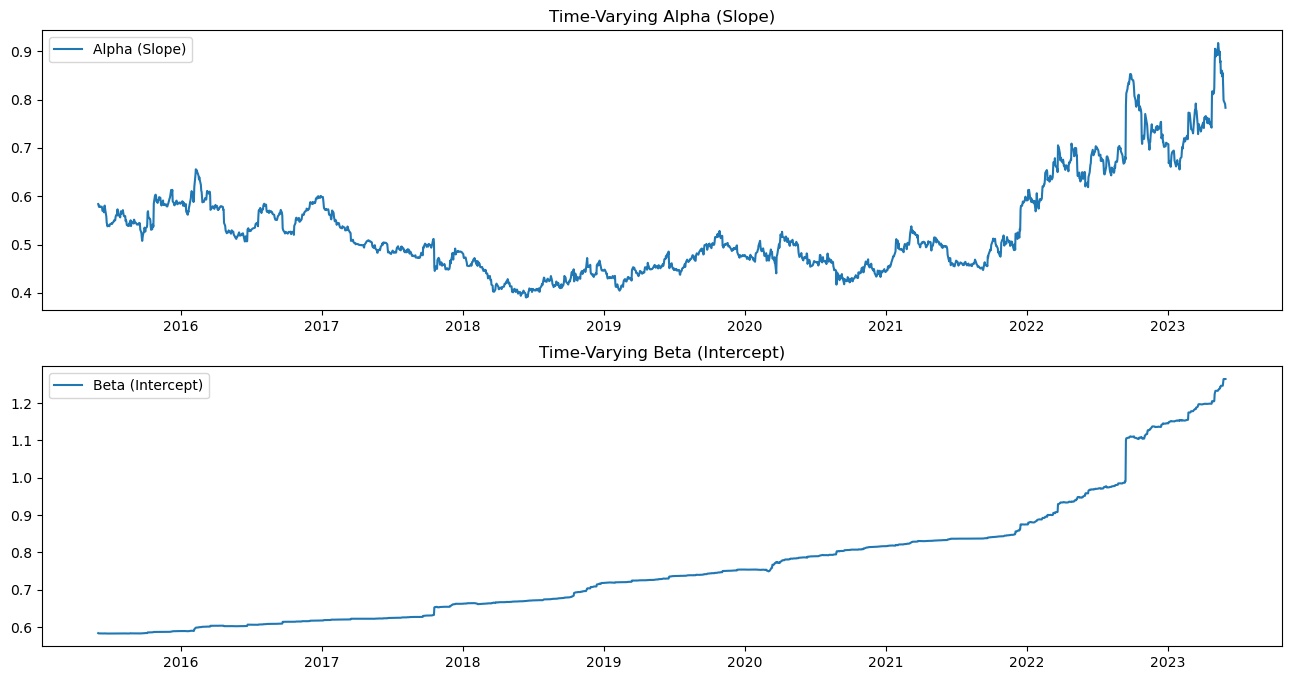

In [288]:
state_means = KalmanFilterRegression(ADBE, MSFT)

# Extract alpha (slope) and beta (intercept) estimates
alpha_estimates = state_means[:, 0]  # Time-varying slope (alpha)
beta_estimates = state_means[:, 1]   # Time-varying intercept (beta)

# Create a DataFrame to visualize the results
kalman_results = pd.DataFrame({'Alpha': alpha_estimates, 'Beta': beta_estimates}, index=MSFT.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))


# Plot time-varying alpha (slope)
plt.subplot(2, 1, 1)

plt.plot(kalman_results['Alpha'], label="Alpha (Slope)")
plt.legend()
plt.title("Time-Varying Alpha (Slope)")

# Plot time-varying beta (intercept)
plt.subplot(2, 1, 2)
plt.plot(kalman_results['Beta'], label="Beta (Intercept)")
plt.legend()
plt.title("Time-Varying Beta (Intercept)")

plt.show()


1410.5


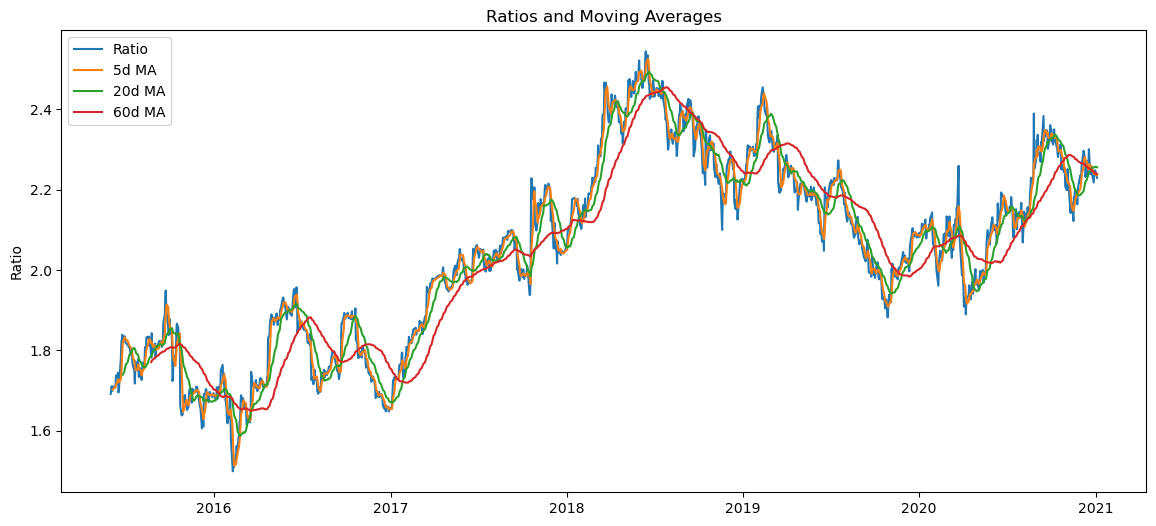

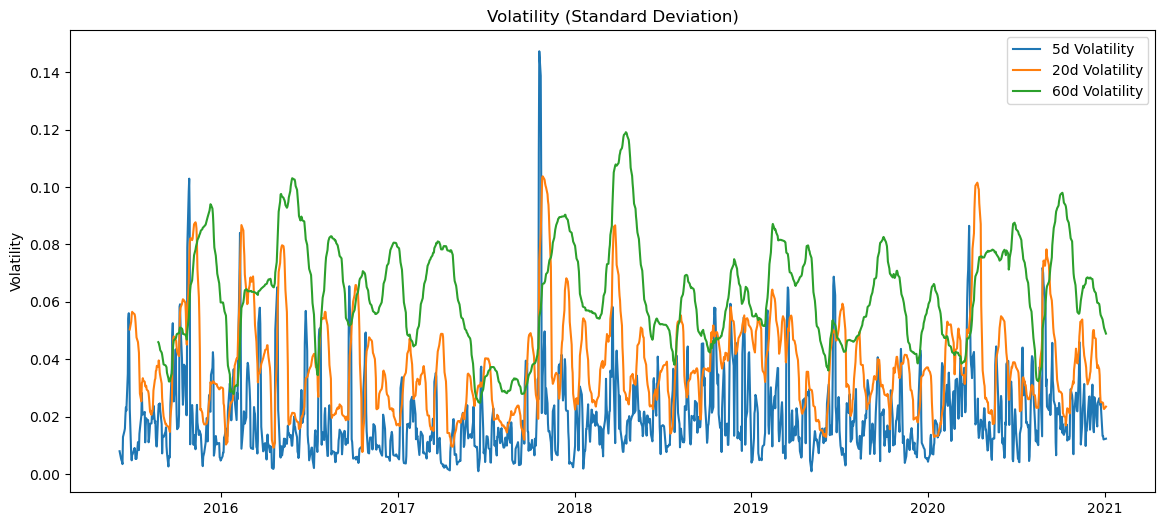

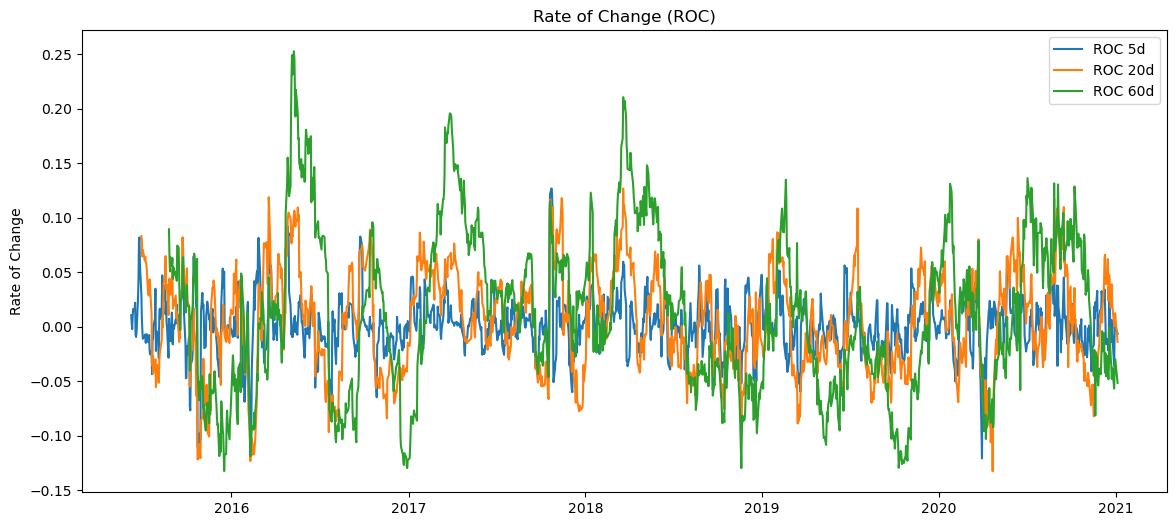

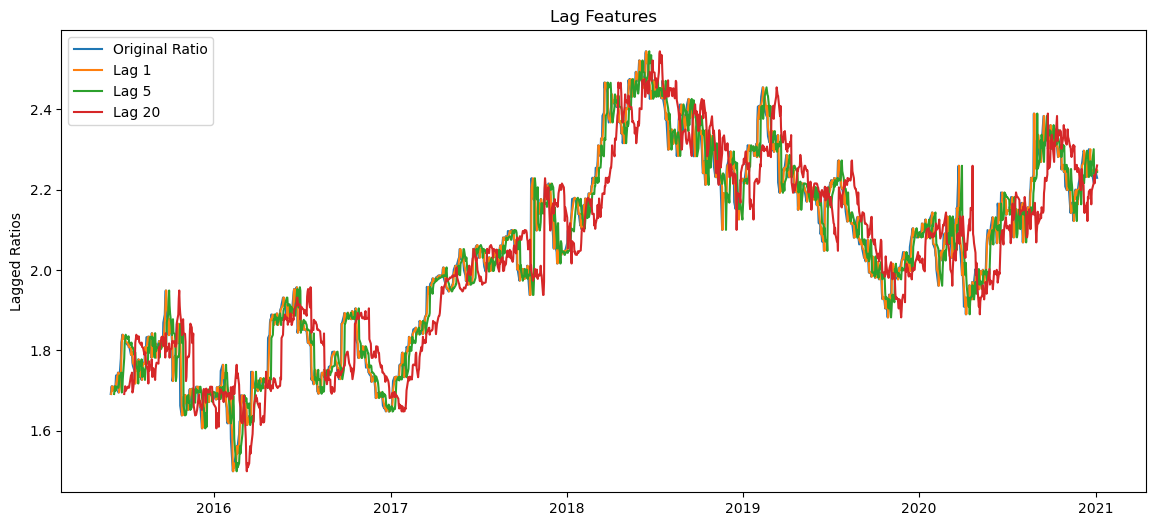

In [289]:
# ratios = df['ADBE'] / df['MSFT']
# print(len(ratios) * .70 )

# train = ratios[:1410]
# test = ratios[1410:]

# ratios_mavg5 = train.rolling(window=5, center=False).mean()
# ratios_mavg60 = train.rolling(window=60, center=False).mean()
# std_60 = train.rolling(window=60, center=False).std()
# zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
# plt.figure(figsize=(12, 6))
# plt.plot(train.index, train.values)
# plt.plot(ratios_mavg5.index, ratios_mavg5.values)
# plt.plot(ratios_mavg60.index, ratios_mavg60.values)
# plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

# plt.ylabel('Ratio')
# plt.show()


import pandas as pd
import matplotlib.pyplot as plt

# Ratios calculation
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) * .70)

# Train-test split
train = ratios[:1410]
test = ratios[1410:]

# Moving Averages
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg20 = train.rolling(window=20, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()

# Standard Deviation (Volatility)
std_5 = train.rolling(window=5, center=False).std()
std_20 = train.rolling(window=20, center=False).std()
std_60 = train.rolling(window=60, center=False).std()

# Rate of Change (ROC)
roc_5 = train.pct_change(periods=5)
roc_20 = train.pct_change(periods=20)
roc_60 = train.pct_change(periods=60)

# Lag Features
train_lag_1 = train.shift(1)  # 1-day lag
train_lag_5 = train.shift(5)  # 5-day lag
train_lag_20 = train.shift(20)  # 20-day lag

# Z-Score for 60-day and 5-day moving average
zscore_60_5 = (ratios_mavg5 - ratios_mavg60) / std_60


# Drop rows with NaNs
train = train.dropna()
ratios_mavg5 = ratios_mavg5.dropna()
ratios_mavg20 = ratios_mavg20.dropna()
ratios_mavg60 = ratios_mavg60.dropna()
std_5 = std_5.dropna()
std_20 = std_20.dropna()
std_60 = std_60.dropna()
roc_5 = roc_5.dropna()
roc_20 = roc_20.dropna()
roc_60 = roc_60.dropna()
train_lag_1 = train_lag_1.dropna()
train_lag_5 = train_lag_5.dropna()
train_lag_20 = train_lag_20.dropna()


# Plotting Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Ratio')
plt.plot(ratios_mavg5.index, ratios_mavg5.values, label='5d MA')
plt.plot(ratios_mavg20.index, ratios_mavg20.values, label='20d MA')
plt.plot(ratios_mavg60.index, ratios_mavg60.values, label='60d MA')
plt.legend()
plt.title('Ratios and Moving Averages')
plt.ylabel('Ratio')
plt.show()

# Plotting Volatility (Standard Deviation)
plt.figure(figsize=(14, 6))
plt.plot(std_5.index, std_5.values, label='5d Volatility')
plt.plot(std_20.index, std_20.values, label='20d Volatility')
plt.plot(std_60.index, std_60.values, label='60d Volatility')
plt.legend()
plt.title('Volatility (Standard Deviation)')
plt.ylabel('Volatility')
plt.show()

# Plotting Rate of Change (ROC)
plt.figure(figsize=(14, 6))
plt.plot(roc_5.index, roc_5.values, label='ROC 5d')
plt.plot(roc_20.index, roc_20.values, label='ROC 20d')
plt.plot(roc_60.index, roc_60.values, label='ROC 60d')
plt.legend()
plt.title('Rate of Change (ROC)')
plt.ylabel('Rate of Change')
plt.show()

# Plotting Lag Features
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Original Ratio')
plt.plot(train_lag_1.index, train_lag_1.values, label='Lag 1')
plt.plot(train_lag_5.index, train_lag_5.values, label='Lag 5')
plt.plot(train_lag_20.index, train_lag_20.values, label='Lag 20')
plt.legend()
plt.title('Lag Features')
plt.ylabel('Lagged Ratios')
plt.show()


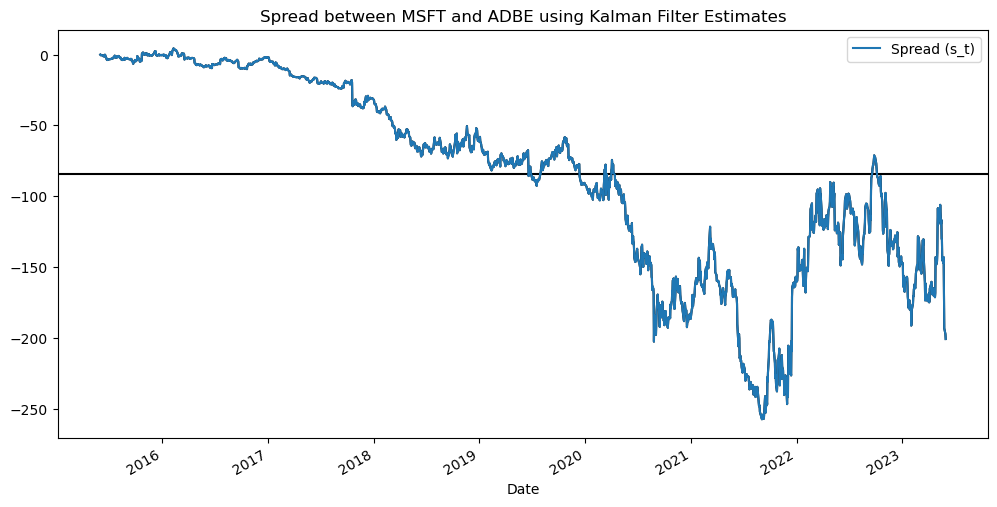

-84.13785283834798


In [290]:
# Calculate the spread s_t
spread = MSFT - (kalman_results['Alpha'] + kalman_results['Beta'] * ADBE)
plt.axhline(spread.mean(), color='black')
# Plot the spread
spread.plot(figsize=(12,6) , color = 'k')
plt.plot(spread, label="Spread (s_t)")
plt.legend()
plt.title("Spread between MSFT and ADBE using Kalman Filter Estimates")
plt.show()

print(spread.mean())

Training Ml

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 0.3649
R^2 Score: 0.7959
             Z_Score Signal
Date                       
2015-08-25 -0.233113   Hold
2015-08-26  0.216953   Hold
2015-08-27  0.427018   Hold
2015-08-28  0.164287   Hold
2015-08-31  0.394043   Hold


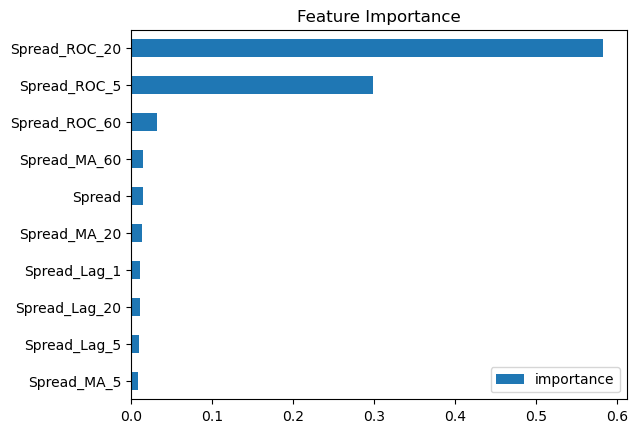

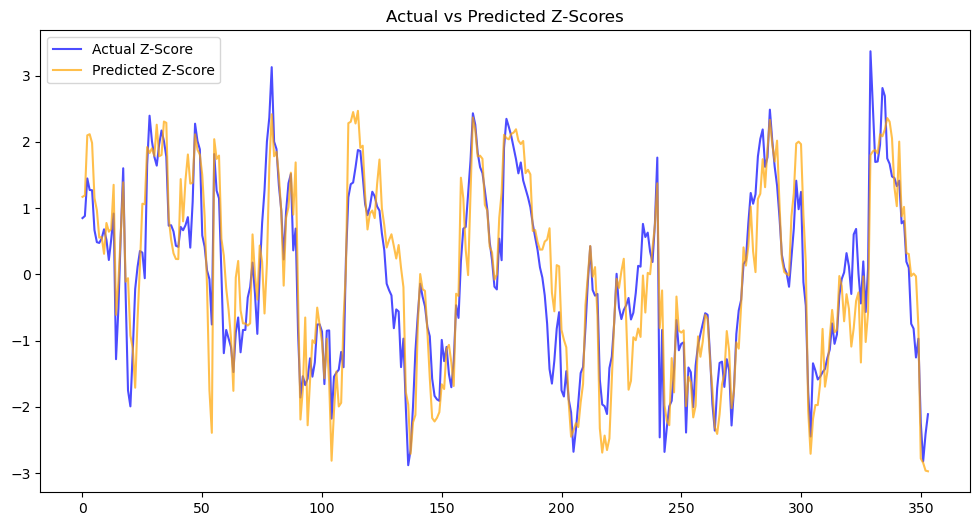

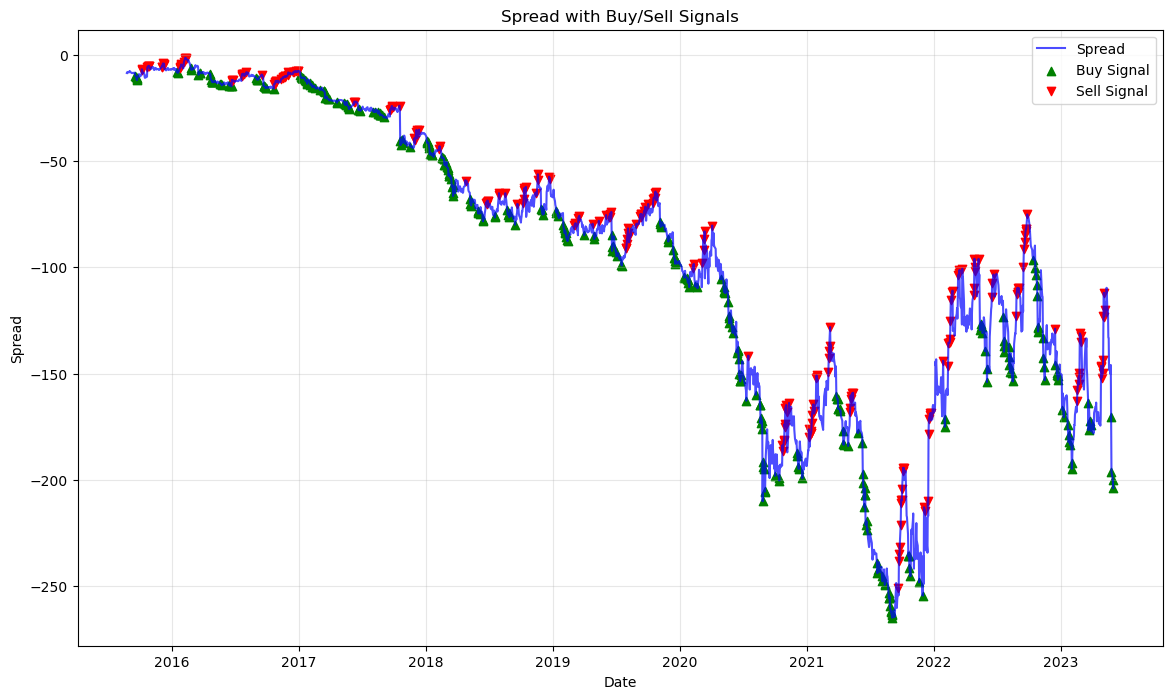

In [291]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

# Load your dataset (assuming you have 'ADBE' and 'MSFT' prices)
data = pd.DataFrame()
data['ADBE'] = yf.download('ADBE', start='2015-01-01', end='2023-12-31')['Adj Close']
data['MSFT'] = yf.download('MSFT', start='2015-01-01', end='2023-12-31')['Adj Close']

# Calculate the spread
spread = data['MSFT'] - (kalman_results['Alpha'] + kalman_results['Beta'] * data['ADBE'])

# Feature Engineering for Spread and Z-Score

ratio = df['ADBE'] / df['MSFT']

data['Ratio'] = ratio
window_size = 20
data['Spread'] = spread
data['Spread_MA_5'] = spread.rolling(window=5).mean()
data['Spread_MA_20'] = spread.rolling(window=20).mean()
data['Spread_MA_60'] = spread.rolling(window=60).mean()
data['Spread_ROC_5'] = spread.pct_change(periods=5)
data['Spread_ROC_20'] = spread.pct_change(periods=20)
data['Spread_ROC_60'] = spread.pct_change(periods=60)
data['Spread_Lag_1'] = spread.shift(1)
data['Spread_Lag_5'] = spread.shift(5)
data['Spread_Lag_20'] = spread.shift(20)
# Calculate rolling mean and std
data['Rolling_Mean'] = spread.rolling(window=window_size).mean()
data['Rolling_Std'] = spread.rolling(window=window_size).std()

# Calculate z-score
data['Z_Score'] = (spread - data['Rolling_Mean']) / data['Rolling_Std']

# Drop rows with NaN values
data = data.dropna()

# Prepare features (X) and target (y)
X = data[['Spread','Spread_MA_5', 'Spread_MA_20', 'Spread_MA_60', 
          'Spread_ROC_5', 'Spread_ROC_20', 'Spread_ROC_60', 
          'Spread_Lag_1', 'Spread_Lag_5', 'Spread_Lag_20' ]]
y = data['Z_Score']

# Split data into train-test sets
X_train = X.loc[X.index < '01-01-2022']
X_test = X.loc[X.index >= '01-01-2022']

y_train = y.loc[y.index < '01-01-2022']
y_test = y.loc[y.index >= '01-01-2022']



# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict z-scores
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")



# Add a column for buy/sell signals
data['Signal'] = np.nan  # Initialize with NaN

# Define thresholds
buy_threshold = -1.5
sell_threshold = 1.5

# Generate signals based on Z-Score
for i in range(len(data)):
    if data['Z_Score'].iloc[i] < buy_threshold:
        data['Signal'].iloc[i] = 'Buy'
    elif data['Z_Score'].iloc[i] > sell_threshold:
        data['Signal'].iloc[i] = 'Sell'
    else:
        data['Signal'].iloc[i] = 'Hold'

# Display the updated DataFrame
print(data[['Z_Score', 'Signal']].head())


# Feature Importance
fi = pd.DataFrame(data=model.feature_importances_,
             index=X.columns,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Plot Actual vs Predicted Z-Scores
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual Z-Score', color='blue', alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label='Predicted Z-Score', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Z-Scores')
plt.legend()
plt.show()



# Plot Spread with Buy/Sell Signals
plt.figure(figsize=(14, 8))

# Plot the spread as a line plot
plt.plot(data.index, data['Spread'], label='Spread', color='blue', alpha=0.7)

# Scatter plot for buy signals
buy_signals = data[data['Signal'] == 'Buy']
plt.scatter(buy_signals.index, buy_signals['Spread'], color='green', label='Buy Signal', marker='^', alpha=1)

# Scatter plot for sell signals
sell_signals = data[data['Signal'] == 'Sell']
plt.scatter(sell_signals.index, sell_signals['Spread'], color='red', label='Sell Signal', marker='v', alpha=1)

# Plot formatting
plt.title('Spread with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



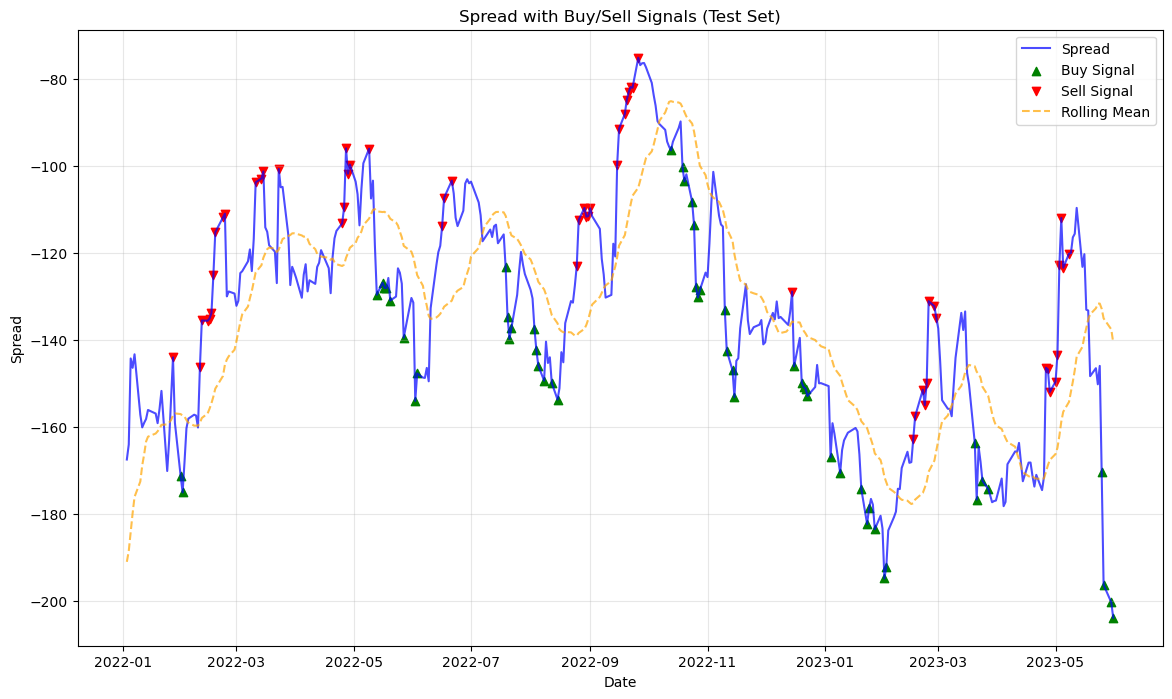

In [292]:
# Filter the test dataset
test_data = data.loc[X_test.index]

# Plot Spread with Buy/Sell Signals for the Test Set
plt.figure(figsize=(14, 8))

# Plot the spread as a line plot
plt.plot(test_data.index, test_data['Spread'], label='Spread', color='blue', alpha=0.7)

# Scatter plot for buy signals in the test set
buy_signals_test = test_data[test_data['Signal'] == 'Buy']
plt.scatter(buy_signals_test.index, buy_signals_test['Spread'], color='green', label='Buy Signal', marker='^', alpha=1)

# Scatter plot for sell signals in the test set
sell_signals_test = test_data[test_data['Signal'] == 'Sell']
plt.scatter(sell_signals_test.index, sell_signals_test['Spread'], color='red', label='Sell Signal', marker='v', alpha=1)

# Plot formatting
plt.plot(test_data.index, test_data['Rolling_Mean'], label='Rolling Mean', color='orange', linestyle='--', alpha=0.7)

plt.title('Spread with Buy/Sell Signals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


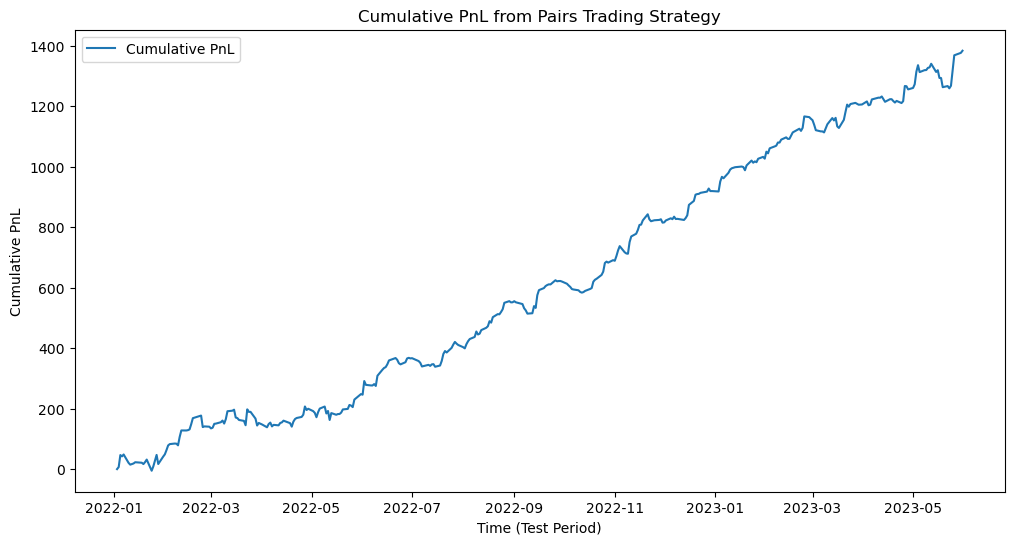

Sharpe Ratio: 4.65
Win Rate: 62.89%
Cumulative PnL: 1383.31


In [293]:
# Define thresholds for strategy
close_threshold = 0.5

# Initialize positions and PnL
position_ADBE = 0
position_MSFT = 0
pnl = []
cumulative_pnl = 0

# Add a column for daily spread change
X_test['Spread_Change'] = -X_test['Spread'].diff()
X_test['Spread_Change'].fillna(0, inplace=True)  # Replace NaN values with 0

# Iterate over the test set
for i in range(len(y_test)):
    z_score = y_test.iloc[i]
    spread_change = X_test['Spread_Change'].iloc[i]

    # Check buy/sell/close signals
    if z_score > buy_threshold:
        # Enter short position on ADBE, long on MSFT
        position_ADBE = -1
        position_MSFT = 1
    elif z_score < sell_threshold:
        # Enter long position on ADBE, short on MSFT
        position_ADBE = 1
        position_MSFT = -1
    elif abs(z_score) < close_threshold:
        # Close positions
        position_ADBE = 0
        position_MSFT = 0

    # Calculate daily PnL
    daily_pnl = (position_ADBE * spread_change) + (position_MSFT * -spread_change)
    cumulative_pnl += daily_pnl
    pnl.append(cumulative_pnl)

# Evaluate the strategy
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, pnl, label="Cumulative PnL")
plt.title("Cumulative PnL from Pairs Trading Strategy")
plt.xlabel("Time (Test Period)")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

# Calculate Sharpe Ratio and Win Rate
daily_returns = np.diff(pnl)
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
win_rate = sum(np.array(daily_returns) > 0) / len(daily_returns)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Cumulative PnL: {cumulative_pnl:.2f}")


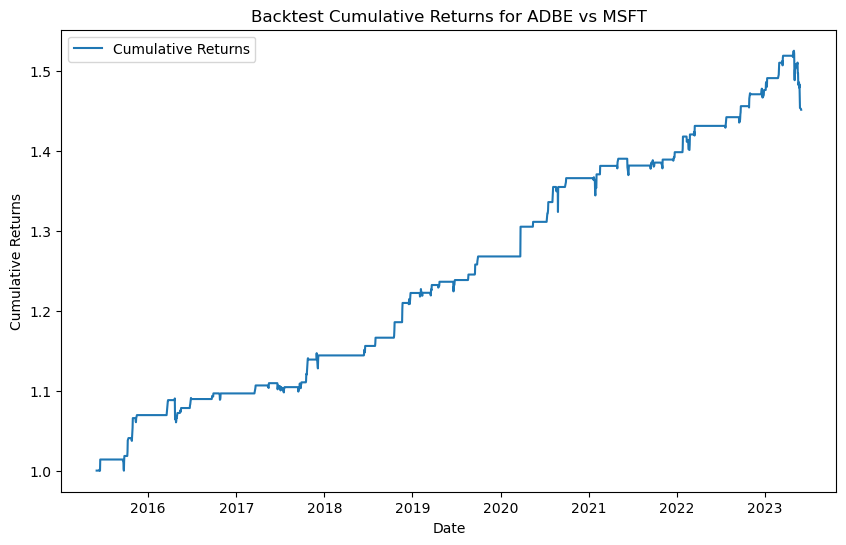

Sharpe Ratio: 1.37


In [294]:
# Run the backtest
cumulative_returns, sharpe_ratio = backtest('ADBE', 'MSFT', ADBE, MSFT)

# Plot the cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Cumulative Returns")
plt.title("Backtest Cumulative Returns for ADBE vs MSFT")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Print the Sharpe ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


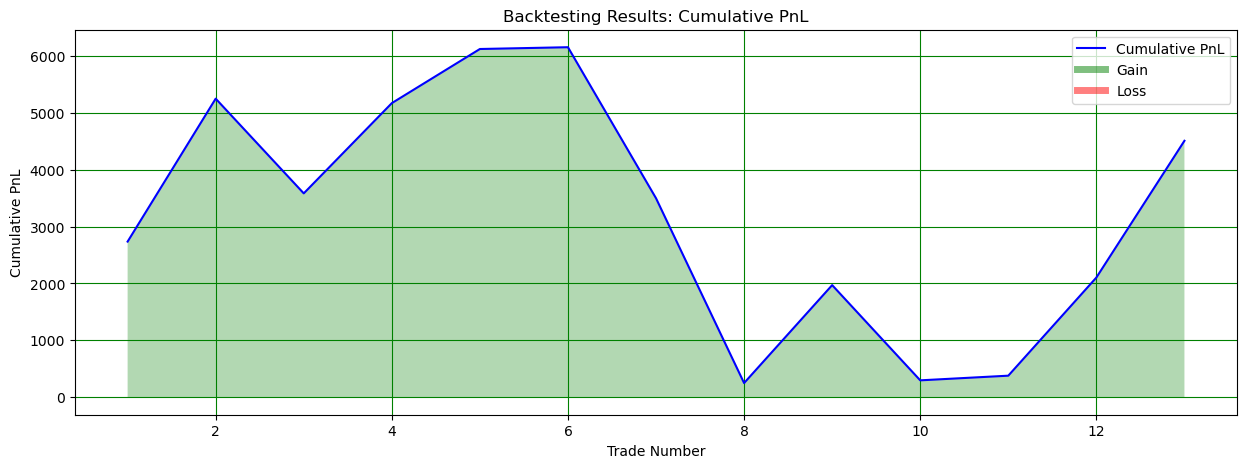

Final Cumulative PnL: 4507.9620981682865
    Trade          PnL  Cumulative_PnL
0       1  2735.961084     2735.961084
1       2  2512.718297     5248.679381
2       3 -1665.053079     3583.626302
3       4  1586.372225     5169.998527
4       5   951.403222     6121.401749
5       6    31.383367     6152.785116
6       7 -2654.939970     3497.845145
7       8 -3248.577735      249.267411
8       9  1721.544822     1970.812233
9      10 -1674.086544      296.725689
10     11    81.922773      378.648462
11     12  1725.445808     2104.094270
12     13  2403.867828     4507.962098
----- Backtesting Summary -----
Total Trades: 13
Winning Trades: 9
Losing Trades: 4
Winning Percentage: 69.23%
Average Winning Trade: 1527.85
Average Losing Trade: -2310.66
Profit Factor: 1.49
Max Drawdown: 249.27
Best Day (Trade): 2735.96
Worst Day (Trade): -3248.58
Average Trade PnL: 346.77
Total PnL: 4507.96
Sharpe Ratio: 2.68


In [295]:
# Step 1: Simulate trading strategy with Hold logic
initial_balance = 100000  # Starting balance
position_size = 100  # Number of units bought/sold per trade
pnl = []  # List to store profit and loss for each trade
position = 0  # Current position (long/short)
entry_price = 0  # Entry price for a position
hold_pnl = 0  # To track unrealized PnL during hold periods

# Iterate over the testing dataset to calculate PnL
for index, row in test_data.iterrows():
    # If a buy signal is triggered
    if row['Signal'] == 'Buy':
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = position_size  # Enter a long position
        elif position < 0:  # Close short position and go long
            pnl.append((entry_price - row['Spread']) * abs(position))
            entry_price = row['Spread']
            position = position_size  # Switch to long
    
    # If a sell signal is triggered
    elif row['Signal'] == 'Sell':
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = -position_size  # Enter a short position
        elif position > 0:  # Close long position and go short
            pnl.append((row['Spread'] - entry_price) * position)
            entry_price = row['Spread']
            position = -position_size  # Switch to short

    # If a hold signal is triggered
    elif row['Signal'] == 'Hold':
        if position > 0:  # Long position is held
            hold_pnl = (row['Spread'] - entry_price) * position
        elif position < 0:  # Short position is held
            hold_pnl = (entry_price - row['Spread']) * abs(position)
        else:
            hold_pnl = 0  # No position, no unrealized PnL

# Step 2: Calculate cumulative PnL
cumulative_pnl = [sum(pnl[:i + 1]) for i in range(len(pnl))]

# Step 3: Create a DataFrame to store trading results
backtest_df = pd.DataFrame({
    'Trade': range(1, len(cumulative_pnl) + 1),
    'PnL': pnl,
    'Cumulative_PnL': cumulative_pnl
})

# Step 4: Evaluate performance and plot cumulative PnL
plt.figure(figsize=(15, 5))
ax1 = plt.subplot()

# Plot cumulative PnL as a line
ax1.plot(backtest_df['Trade'], backtest_df['Cumulative_PnL'], '-', label='Cumulative PnL', color='blue')

# Legend placeholders for gain/loss shading
ax1.plot([], [], linewidth=5, label='Gain', color='g', alpha=0.5)
ax1.plot([], [], linewidth=5, label='Loss', color='r', alpha=0.5)

# Shading for gain/loss
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] >= 0),
    facecolor='g',
    alpha=0.3,
    interpolate=True
)
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] < 0),
    facecolor='r',
    alpha=0.3,
    interpolate=True
)

# Chart settings
plt.title('Backtesting Results: Cumulative PnL')
ax1.grid(True, color='g', linestyle='-')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

# Print summary of results
print("Final Cumulative PnL:", cumulative_pnl[-1])
print(backtest_df)



#####################################################


import pandas as pd
import matplotlib.pyplot as plt

# Calculate key statistics
total_trades = len(pnl)  # Total number of trades
winning_trades = len([p for p in pnl if p > 0])  # Count of winning trades
losing_trades = len([p for p in pnl if p <= 0])  # Count of losing trades
winning_percent = (winning_trades / total_trades) * 100 if total_trades > 0 else 0  # Win percentage
avg_winning_trade = sum([p for p in pnl if p > 0]) / winning_trades if winning_trades > 0 else 0  # Avg win
avg_losing_trade = sum([p for p in pnl if p <= 0]) / losing_trades if losing_trades > 0 else 0  # Avg loss
profit_factor = (sum([p for p in pnl if p > 0]) / abs(sum([p for p in pnl if p <= 0]))) if losing_trades > 0 else float('inf')  # Profit Factor
max_drawdown = min(backtest_df['Cumulative_PnL'])  # Maximum drawdown
best_day = max(pnl) if pnl else 0  # Best single trade PnL
worst_day = min(pnl) if pnl else 0  # Worst single trade PnL
avg_trade_pnl = sum(pnl) / total_trades if total_trades > 0 else 0  # Avg PnL per trade
total_pnl = sum(pnl)  # Total PnL
sharpe_ratio = (avg_trade_pnl / (pd.Series(pnl).std() if pd.Series(pnl).std() > 0 else 1)) * (252**0.5) if total_trades > 1 else 0  # Annualized Sharpe Ratio

# Print key metrics
print("----- Backtesting Summary -----")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Winning Percentage: {winning_percent:.2f}%")
print(f"Average Winning Trade: {avg_winning_trade:.2f}")
print(f"Average Losing Trade: {avg_losing_trade:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Best Day (Trade): {best_day:.2f}")
print(f"Worst Day (Trade): {worst_day:.2f}")
print(f"Average Trade PnL: {avg_trade_pnl:.2f}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


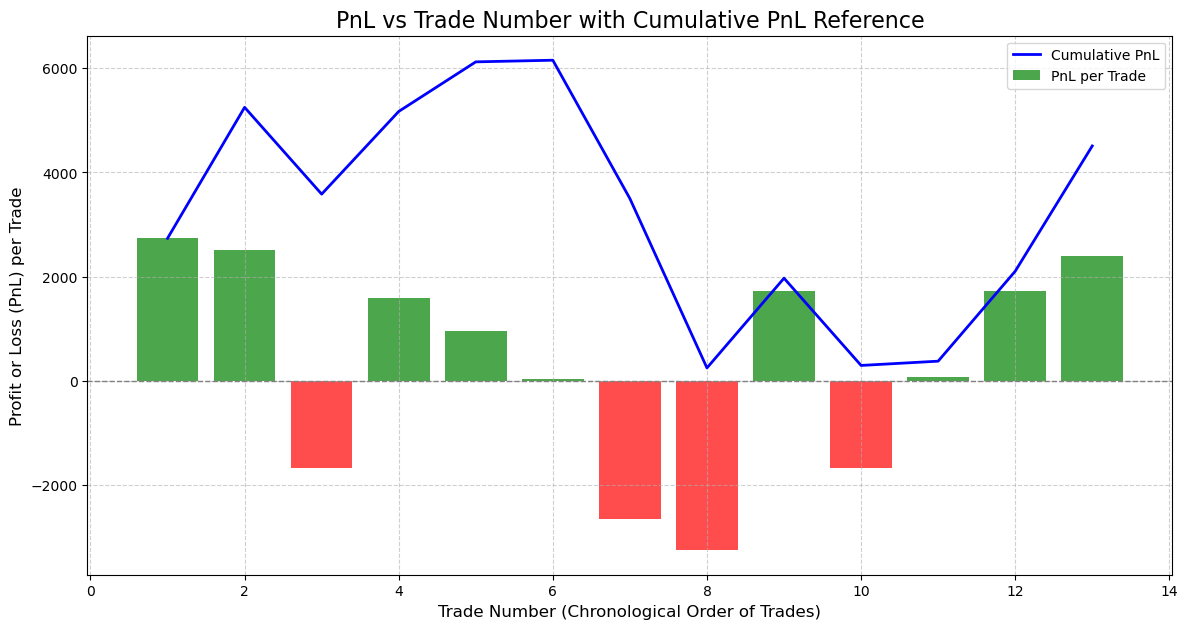

In [296]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot PnL for each trade (bar plot)
plt.bar(backtest_df['Trade'], backtest_df['PnL'], 
        color=['g' if x >= 0 else 'r' for x in backtest_df['PnL']],
        alpha=0.7, label='PnL per Trade')

# Add cumulative PnL line for reference
plt.plot(backtest_df['Trade'], backtest_df['Cumulative_PnL'], 
         label='Cumulative PnL', color='blue', linewidth=2)

# Add horizontal zero line for reference
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Detailed X and Y labels
plt.title('PnL vs Trade Number with Cumulative PnL Reference', fontsize=16)
plt.xlabel('Trade Number (Chronological Order of Trades)', fontsize=12)
plt.ylabel('Profit or Loss (PnL) per Trade', fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show plot
plt.show()


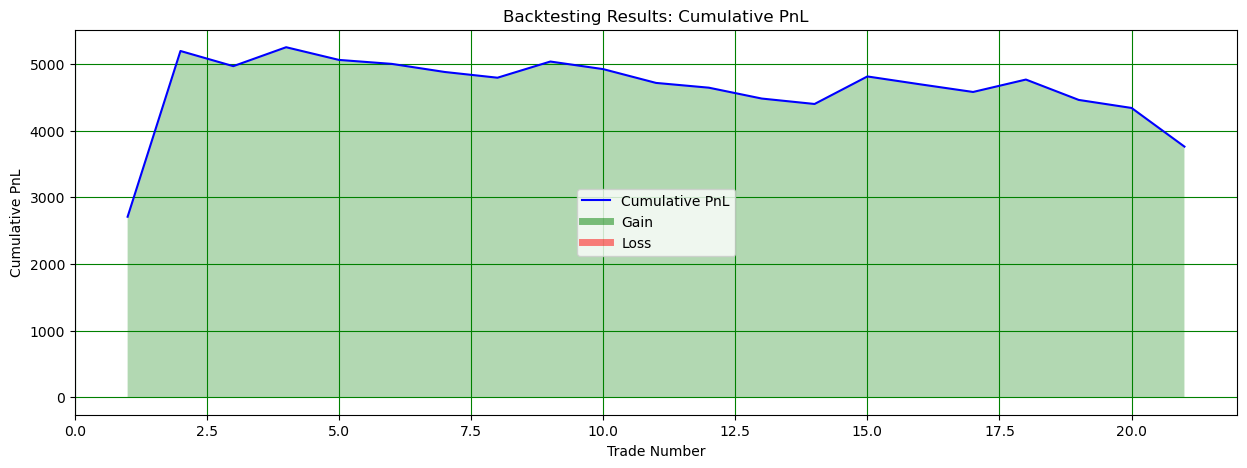

----- Backtesting Summary -----
Total Trades: 21
Winning Trades: 6
Losing Trades: 15
Winning Percentage: 28.57%
Average Winning Trade: 1053.80
Average Losing Trade: -170.78
Profit Factor: 2.47
Max Drawdown: 2708.60
Best Day (Trade): 2708.60
Worst Day (Trade): -579.90
Average Trade PnL: 179.10
Total PnL: 3761.12
Sharpe Ratio: 3.41


In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
initial_balance = 100000  # Starting balance
base_position_size = 100  # Base number of units bought/sold per trade
stop_loss_threshold = 50  # Stop-loss threshold
volatility_window = 20  # Rolling window for volatility calculation
pnl = []  # List to store profit and loss for each trade
position = 0  # Current position (long/short)
entry_price = 0  # Entry price for a position
hold_pnl = 0  # To track unrealized PnL during hold periods

# Simulate trading strategy
for row_number, (index, row) in enumerate(test_data.iterrows()):
    # Calculate volatility (rolling standard deviation)
    if row_number >= volatility_window:
        spread_volatility = test_data['Spread'].iloc[row_number - volatility_window:row_number].std()
    else:
        spread_volatility = 1  # Default value before sufficient data


    # Adjust position size based on volatility
    position_size = int(base_position_size / (spread_volatility + 1e-5))  # Avoid division by zero

    # If a buy signal is triggered
    if row['Signal'] == 'Buy':
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = position_size  # Enter a long position
        elif position < 0:  # Close short position and go long
            pnl.append((entry_price - row['Spread']) * abs(position))
            entry_price = row['Spread']
            position = position_size  # Switch to long

    # If a sell signal is triggered
    elif row['Signal'] == 'Sell':
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = -position_size  # Enter a short position
        elif position > 0:  # Close long position and go short
            pnl.append((row['Spread'] - entry_price) * position)
            entry_price = row['Spread']
            position = -position_size  # Switch to short

    # If a hold signal is triggered
    elif row['Signal'] == 'Hold':
        if position > 0:  # Long position is held
            hold_pnl = (row['Spread'] - entry_price) * position
        elif position < 0:  # Short position is held
            hold_pnl = (entry_price - row['Spread']) * abs(position)
        else:
            hold_pnl = 0  # No position, no unrealized PnL

    # Apply stop-loss logic
    if hold_pnl < -stop_loss_threshold:
        pnl.append(hold_pnl)
        position = 0  # Exit the position
        hold_pnl = 0

# Step 2: Calculate cumulative PnL
cumulative_pnl = [sum(pnl[:i + 1]) for i in range(len(pnl))]

# Step 3: Create a DataFrame to store trading results
backtest_df = pd.DataFrame({
    'Trade': range(1, len(cumulative_pnl) + 1),
    'PnL': pnl,
    'Cumulative_PnL': cumulative_pnl
})

# Step 4: Evaluate performance and plot cumulative PnL
plt.figure(figsize=(15, 5))
ax1 = plt.subplot()

# Plot cumulative PnL as a line
ax1.plot(backtest_df['Trade'], backtest_df['Cumulative_PnL'], '-', label='Cumulative PnL', color='blue')

# Legend placeholders for gain/loss shading
ax1.plot([], [], linewidth=5, label='Gain', color='g', alpha=0.5)
ax1.plot([], [], linewidth=5, label='Loss', color='r', alpha=0.5)

# Shading for gain/loss
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] >= 0),
    facecolor='g',
    alpha=0.3,
    interpolate=True
)
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] < 0),
    facecolor='r',
    alpha=0.3,
    interpolate=True
)

# Chart settings
plt.title('Backtesting Results: Cumulative PnL')
ax1.grid(True, color='g', linestyle='-')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

# Step 5: Calculate key statistics
total_trades = len(pnl)  # Total number of trades
winning_trades = len([p for p in pnl if p > 0])  # Count of winning trades
losing_trades = len([p for p in pnl if p <= 0])  # Count of losing trades
winning_percent = (winning_trades / total_trades) * 100 if total_trades > 0 else 0  # Win percentage
avg_winning_trade = sum([p for p in pnl if p > 0]) / winning_trades if winning_trades > 0 else 0  # Avg win
avg_losing_trade = sum([p for p in pnl if p <= 0]) / losing_trades if losing_trades > 0 else 0  # Avg loss
profit_factor = (sum([p for p in pnl if p > 0]) / abs(sum([p for p in pnl if p <= 0]))) if losing_trades > 0 else float('inf')  # Profit Factor
max_drawdown = min(backtest_df['Cumulative_PnL'])  # Maximum drawdown
best_day = max(pnl) if pnl else 0  # Best single trade PnL
worst_day = min(pnl) if pnl else 0  # Worst single trade PnL
avg_trade_pnl = sum(pnl) / total_trades if total_trades > 0 else 0  # Avg PnL per trade
total_pnl = sum(pnl)  # Total PnL
sharpe_ratio = (avg_trade_pnl / (pd.Series(pnl).std() if pd.Series(pnl).std() > 0 else 1)) * (252**0.5) if total_trades > 1 else 0  # Annualized Sharpe Ratio

# Print key metrics
print("----- Backtesting Summary -----")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Winning Percentage: {winning_percent:.2f}%")
print(f"Average Winning Trade: {avg_winning_trade:.2f}")
print(f"Average Losing Trade: {avg_losing_trade:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Best Day (Trade): {best_day:.2f}")
print(f"Worst Day (Trade): {worst_day:.2f}")
print(f"Average Trade PnL: {avg_trade_pnl:.2f}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


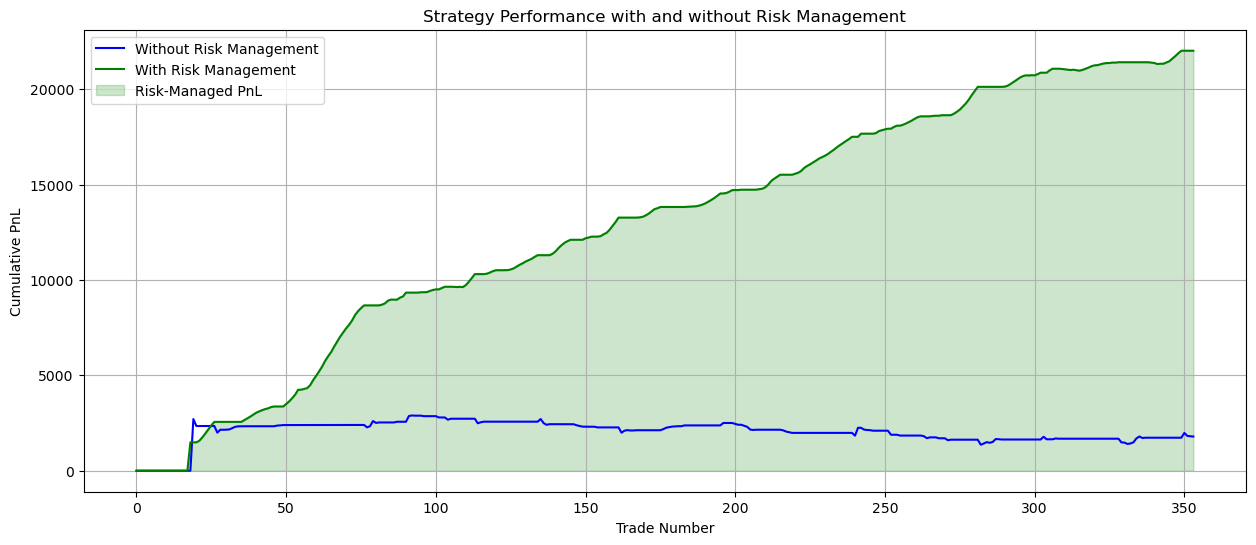

----- Performance Comparison -----
Total PnL Without Risk Management: 1792.16
Total PnL With Risk Management: 22023.08
Max Drawdown Without Risk Management: 0.00
Max Drawdown With Risk Management: 0.00


In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
initial_balance = 100000
base_position_size = 100
stop_loss_threshold = 50
volatility_window = 20
max_position_size = 200  # Maximum position size
trailing_stop_factor = 0.05  # Trailing stop-loss as a percentage of the entry price
daily_pnl_cap = -500  # Daily loss cap
max_drawdown_limit = -1000  # Max drawdown limit

# Data Structures
pnl_with_risk = []
pnl_without_risk = []
cumulative_pnl_without_risk = []
cumulative_pnl_with_risk = []

# Helper variables
position_with_risk = 0
entry_price_with_risk = 0
daily_pnl = 0
max_cumulative_pnl = 0
hold_pnl_with_risk = 0

# Simulate trading strategy with risk management
for row_number, (index, row) in enumerate(test_data.iterrows()):
    # Calculate volatility (rolling standard deviation)
    if row_number >= volatility_window:
        spread_volatility = test_data['Spread'].iloc[row_number - volatility_window:row_number].std()
    else:
        spread_volatility = 1

    # Adjust position size based on volatility
    position_size = int(base_position_size / (spread_volatility + 1e-5))
    position_size = min(position_size, max_position_size)  # Apply position size cap

    # Without Risk Management
    pnl_wo = 0
    if row['Signal'] == 'Buy':
        pnl_wo = (row['Spread'] - entry_price_with_risk) * position_with_risk
        position_with_risk = position_size
        entry_price_with_risk = row['Spread']
    elif row['Signal'] == 'Sell':
        pnl_wo = (entry_price_with_risk - row['Spread']) * position_with_risk
        position_with_risk = -position_size
        entry_price_with_risk = row['Spread']
    pnl_without_risk.append(pnl_wo)

    # With Risk Management
    if position_with_risk > 0:  # Long
        hold_pnl_with_risk = (row['Spread'] - entry_price_with_risk) * position_with_risk
    elif position_with_risk < 0:  # Short
        hold_pnl_with_risk = (entry_price_with_risk - row['Spread']) * abs(position_with_risk)

    if row['Signal'] == 'Buy' or row['Signal'] == 'Sell':
        if daily_pnl < daily_pnl_cap or max_cumulative_pnl + hold_pnl_with_risk < max_drawdown_limit:
            position_with_risk = 0  # Close position under risk limits
            hold_pnl_with_risk = 0
        elif position_with_risk > 0 and row['Spread'] - entry_price_with_risk < -stop_loss_threshold:
            position_with_risk = 0
        elif position_with_risk < 0 and entry_price_with_risk - row['Spread'] < -stop_loss_threshold:
            position_with_risk = 0

    pnl_with_risk.append(hold_pnl_with_risk)

# Calculate Cumulative PnL
cumulative_pnl_without_risk = np.cumsum(pnl_without_risk)
cumulative_pnl_with_risk = np.cumsum(pnl_with_risk)

# Visualization
plt.figure(figsize=(15, 6))

# Plot cumulative PnL without risk management
plt.plot(cumulative_pnl_without_risk, label='Without Risk Management', color='blue')

# Plot cumulative PnL with risk management
plt.plot(cumulative_pnl_with_risk, label='With Risk Management', color='green')

# Highlight risk management exit points
plt.fill_between(range(len(cumulative_pnl_with_risk)), cumulative_pnl_with_risk, color='green', alpha=0.2, label='Risk-Managed PnL')

# Settings
plt.title('Strategy Performance with and without Risk Management')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

# Key Performance Metrics Comparison
print("----- Performance Comparison -----")
print(f"Total PnL Without Risk Management: {cumulative_pnl_without_risk[-1]:.2f}")
print(f"Total PnL With Risk Management: {cumulative_pnl_with_risk[-1]:.2f}")
print(f"Max Drawdown Without Risk Management: {min(cumulative_pnl_without_risk):.2f}")
print(f"Max Drawdown With Risk Management: {min(cumulative_pnl_with_risk):.2f}")
